### 1. Outlier Detection

---
The most straightforward approach to detecting potential fraud is identifying abnormal transactions. By "abnormal," we refer to transactions where certain features deviate significantly from the expected patterns.

Below is a list of some widely used outlier detection methods for testing:

1️⃣ Z-score (Statistic-based)  
2️⃣ Interquartile Range (IQR) (Statistic-based)  
3️⃣ Density-Based Spatial Clustering of Applications with Noise (DBSCAN) (Density-based)  
4️⃣ One-Class Support Vector Machine (SVM) (Machine Learning-based)  
5️⃣ Gaussian Mixiture Model (GMM) (Probability-based)  
6️⃣ K-Nearest Neighbors (KNN) (Distance-based)

First, I take on the **Z-score** and **IQR** methods only with **continuous** columns, excluding discrete features. This is because these statistical approaches are ineffective for detecting anomalies in categorical data, such as encoded values (`red = 0`, `blue = 1`), where "outlier-ness" cannot be meaningfully assessed.

I will then expriment with the remaining **unsupervised** machine learnings. A major advantage of unsupervised learning over supervised learning is that it does not require labeled data. In supervised learning, a dataset must be carefully annotated with correct outputs, which can be time-consuming and costly. Unsupervised learning, on the other hand, can uncover hidden patterns and structures in raw, unlabeled data, making it ideal for discovering insights in situations where labeled data is scarce or unavailable.

This makes unsupervised learning particularly useful for tasks like clustering, anomaly detection, and dimensionality reduction, where patterns emerge naturally from the data without predefined categories. It is like letting the AI explore freely rather than being restricted to learning only from predetermined examples.

#### Data Loading
---

In [2]:
import os
from google.colab import userdata

# Copy Colab secrets as env vars
os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')
os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')

In [3]:
!pwd

/content


In [4]:
# `import opendatasets as od` might not be flexible, so just make direct Kaggle API calls
from kaggle.api.kaggle_api_extended import KaggleApi
from tqdm import tqdm

# Initialize Kaggle API
api = KaggleApi()

# This authenticate() first looks for ~/.config/kaggle/kaggle.json (downloaded from Kaggle | Settings | API | Create New Token that includes username and API key)
# If the JSON file is not present the command looks into the env vars
api.authenticate()

# Dataset identifier
owner = "sgpjesus"
dataset = "bank-account-fraud-dataset-neurips-2022"
owner_and_dataset_name = owner + "/" + dataset
download_zip_file_name = dataset + ".zip"
extracted_csv_file_name = "Base.csv"

# Get dataset metadata to retrieve file size
dataset_metadata = api.dataset_list_files(owner_and_dataset_name).files

In [5]:
import pprint
pprint.pprint(dataset_metadata)

[{"ref": "", "datasetRef": "", "ownerRef": "", "name": "Base.csv", "creationDate": "2023-11-29T11:32:19.356Z", "description": "", "fileType": "", "url": "", "totalBytes": 213427735, "columns": []},
 {"ref": "", "datasetRef": "", "ownerRef": "", "name": "Variant I.csv", "creationDate": "2023-11-29T11:32:19.724Z", "description": "", "fileType": "", "url": "", "totalBytes": 213400445, "columns": []},
 {"ref": "", "datasetRef": "", "ownerRef": "", "name": "Variant II.csv", "creationDate": "2023-11-29T11:32:19.511Z", "description": "", "fileType": "", "url": "", "totalBytes": 213537521, "columns": []},
 {"ref": "", "datasetRef": "", "ownerRef": "", "name": "Variant III.csv", "creationDate": "2023-11-29T11:32:21.193Z", "description": "", "fileType": "", "url": "", "totalBytes": 252204320, "columns": []},
 {"ref": "", "datasetRef": "", "ownerRef": "", "name": "Variant IV.csv", "creationDate": "2023-11-29T11:32:20.744Z", "description": "", "fileType": "", "url": "", "totalBytes": 213538370, "c

In [6]:
api.dataset_metadata(owner_and_dataset_name, path=".")
!cat ./dataset-metadata.json

"{\"datasetId\": 2673949, \"datasetSlug\": \"bank-account-fraud-dataset-neurips-2022\", \"ownerUser\": \"sgpjesus\", \"usabilityRating\": 1.0, \"totalViews\": 96776, \"totalVotes\": 172, \"totalDownloads\": 14892, \"title\": \"Bank Account Fraud Dataset Suite (NeurIPS 2022)\", \"subtitle\": \"Biased, Imbalanced, Dynamic Tabular Datasets for ML Evaluation.\", \"description\": \"The Bank Account Fraud (BAF) suite of datasets has been published at **NeurIPS 2022** and it comprises a total of 6 different synthetic bank account fraud tabular datasets. BAF is a realistic, complete, and robust test bed to evaluate novel and existing methods in ML and fair ML, and the first of its kind!\\n\\n\\n**This suite of datasets is:**\\n- Realistic, based on a present-day real-world dataset for fraud detection;\\n- Biased, each dataset has distinct controlled types of bias;\\n- Imbalanced, this setting presents a extremely low prevalence of positive class;\\n- Dynamic, with temporal data and observed di

In [7]:
total_csv_file_size = sum([csv_file.total_bytes for csv_file in dataset_metadata])

# Download dataset with progress tracking
with tqdm(total=total_csv_file_size, unit='B', unit_scale=True, unit_divisor=1024, desc="Downloading Dataset") as bar:
    api.dataset_download_files(owner_and_dataset_name, path=".", unzip=False)
    downloaded_size = os.path.getsize(download_zip_file_name)
    bar.update(downloaded_size)

print("Download complete!")


Dataset URL: https://www.kaggle.com/datasets/sgpjesus/bank-account-fraud-dataset-neurips-2022


Download complete!


In [8]:
#import zipfile module
from zipfile import ZipFile

with ZipFile(dataset + ".zip", "r") as f:
  #extract only one file, Base.csv, in current directory
  f.extract(extracted_csv_file_name)

#### Preprocessing
---


In [49]:
# Libraries
import pandas as pd
import seaborn as sns
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import FuncFormatter

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from scipy.stats import zscore

from sklearn.metrics import confusion_matrix

In [50]:
# Define a function to format the ticks
def format_thousands(x):
    return f"{int(x):,}"

In [51]:
pd.set_option("display.max_columns", None)
df = pd.read_csv(extracted_csv_file_name)
print(df.head())

ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

In [53]:
label_target ="fraud_bool"
label_zscore = "Z-score"
label_iqr = "IQR"
label_outlier_count = "Outlier Counts"
label_feature = "Features"
label_count = "Counts"
label_fraud_count = "Fraud Cases"
label_fraud = "Fraud"
label_method = "Methods"
label_value = "Values"

label_predicted_values = "Predicted Values"
label_precision = "Precision"
label_recall = "Recall"
label_f1score = "F1-score"

format_decimals = ".2f"

# def format_thousands(var) -> str:
#   return f"{var:,.0f}" if type(var) == int or type(var) == float else "{x:,.0f}"

In [ ]:
total_fraud_count = (df[label_target] == 1).sum()

# def add_thousand_separator_to_int(num: int) -> str:
#   return "{:,}".format(num)

print("This dataset includes " +
      format_thousands(df.shape[0]) +
      " rows, of which " +
      format_thousands(total_fraud_count) +
      " are marked as fraud.")

In [90]:
# The number of columns
print(df.shape[1])

31


In [ ]:
print(df.describe())

In [ ]:
# This stats table omits categorical values!
print(df.describe().shape[1])

In [ ]:
# Drop the "device_fraud_count" column as all zeros
df = df.drop("device_fraud_count", axis=1)

In [ ]:
print("The numbere of missing data cell count = " + str(df.isnull().any(axis=1).sum()))

In [ ]:
print(df.dtypes)

In [ ]:
X = df.copy()

# Seprate the dependent/target variable
y = X.pop(label_target)

# Loop through every column
for column in X.columns:
    # Check if the column is of type 'int64' and contains only 0 and 1
    if X[column].dtype == "int64" and X[column].isin([0, 1]).all():
        # Convert to boolean type
        X[column] = X[column].astype(bool)

print(X.dtypes)

In [ ]:
# There is no point of applying correlation or StandardScaler on "bool" and "object (string)"" as they would be meaningless
# Cannot remove both at one go, so one by one
X_no_bool = X.select_dtypes(exclude=bool)
X_no_string_or_bool = X_no_bool.select_dtypes(exclude=["object"])

In [ ]:
# Create a heatmap using seaborn
plt.figure(figsize=(8, 6))

# The defaulgt annot_kws's size is 10
sns.heatmap(X_no_string_or_bool.corr(method="pearson"), annot=True, annot_kws={"size": 6}, cmap="coolwarm", fmt=format_decimals, linewidths=0.5)

plt.title("Correlation Matrix Heatmap")
plt.show()

Virtually no one feature strongly correlates with another - **linearly**.

#### Normally distributed or skewed?
---
Comparing StandardScaler and MinMaxScaler helps find out the answer.

INSERT THE FIG

In [23]:
def draw_boxplot(data: pd.DataFrame,
                 title: str,
                 ylabel: str,
                 xlabel: str) -> None:
  plt.figure(figsize=(6, 4))
  sns.boxplot(data=data, orient="h") # Flips x and y axes by "orient="h"
  plt.title(title)
  plt.ylabel(ylabel)
  plt.xlabel(xlabel)
  plt.grid(True)
  plt.show()

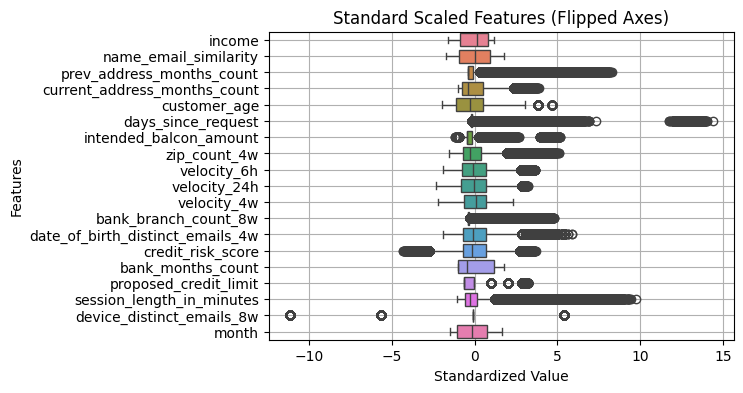

In [24]:
scaler = StandardScaler()
X_standard_scaled = pd.DataFrame(scaler.fit_transform(X_no_string_or_bool), columns=X_no_string_or_bool.columns)

draw_boxplot(X_standard_scaled,
             "Standard Scaled Features (Flipped Axes)",
             label_feature,
             "Standardized Value")

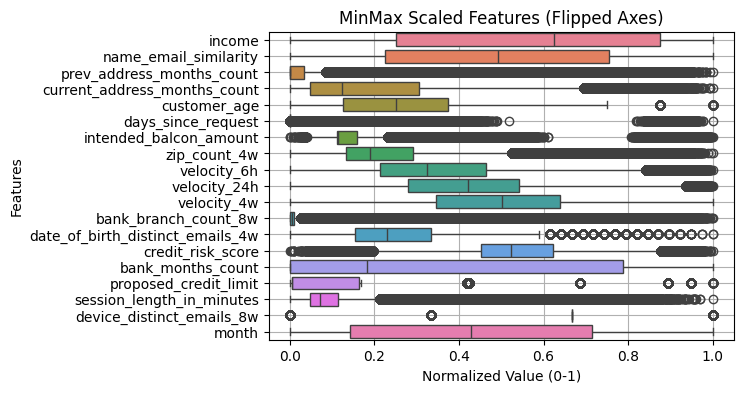

In [25]:
# Apply MinMaxScaler
minmax_scaler = MinMaxScaler()
X_minmax_scaled = pd.DataFrame(minmax_scaler.fit_transform(X_no_string_or_bool), columns=X_no_string_or_bool.columns)

draw_boxplot(X_minmax_scaled,
             "MinMax Scaled Features (Flipped Axes)",
             label_feature,
             "Normalized Value (0-1)")

# # Plot with flipped axes
# plt.figure(figsize=(6, 4))
# sns.boxplot(data=X_minmax_scaled, orient="h") # Flips x and y axes by "orient="h""
# plt.title("MinMax Scaled Features (Flipped Axes)")
# plt.xlabel("Normalized Value (0-1)")
# plt.ylabel("Features")
# plt.grid(True)
# plt.show()

Outliers play a significant role in how **StandardScaler** and **MinMaxScaler** transform data, which can lead to differences in their resulting shapes.

Here's why:

1. StandardScaler (Z-score normalization)
   - Centers the data (zero mean) and scales it to unit variance.  
   - Outliers stretch the scale, influencing the mean and standard deviation.  
   - This can cause a more spread-out distribution in the transformed data.

2. MinMaxScaler (Range normalization)
   - Scales values to a fixed range, typically `[0,1]`.  
   - Outliers compress the distribution, pushing regular values closer together.  
   - This leads to more skewed and squeezed transformations if extreme values are present.

Why do their shapes differ?  
- If there are many outliers, StandardScaler will maintain a broader spread, whereas MinMaxScaler will compress most values into a tight range while stretching extreme ones.  
- This results in different distributions and potentially distinct shapes when visualizing the scaled data.



#### 1. Statistic-based Method (Z-score and IQR)
---
When **Z-score** is more useful than **IQR**?  
1. When Data is Normally Distributed (Bell-Shaped)
    - Z-score assumes data follows a Gaussian (normal) distribution.
    - If your dataset is symmetric and bell-shaped, Z-score is ideal because it standardizes values based on mean and standard deviation.

2. When Detecting Outliers in Continuous Data
    - Works best for datasets with continuous numerical values, such as age, income, or temperatures.
    - Since Z-score transforms values into a standardized scale, it effectively spots extreme deviations.

3. When Working with Large Datasets
    - In massive datasets, IQR can struggle to detect subtle variations.
    - Z-score scales well and provides a more precise measure of how far a data point deviates from the mean.

4. When You Need a Standardized Measure for Comparison
    - Z-score allows comparisons across different datasets.
    - For example, if two different datasets have different scales (one in dollars, another in kilograms), Z-score makes values comparable by converting them to standard deviations.

5. When You Expect Global Outliers (Extreme Deviations)
    - Z-score effectively captures global outliers, meaning data points that are extremely different from the overall dataset.
    - IQR is better at detecting local outliers, meaning values that might be extreme in a specific subset but not necessarily across the entire dataset.


In [26]:
def get_zscore_per_col(series: pd.Series) -> pd.Series:
    return np.abs(zscore(series)) > 3

def get_iqr_per_col(series: pd.Series) -> pd.Series:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    return (df[col] < (Q1 - 1.5 * IQR)) | (df[col] > (Q3 + 1.5 * IQR))

In [27]:
outlier_method_and_result_list = [[label_zscore], [label_iqr]]

# Initialize outlier counter
outlier_counter = pd.Series(0, index=df.index, name = label_outlier_count)

for method_idx in range(len(outlier_method_and_result_list)):
  # No point in using "X_standard_scaled" as the base dataframe because it is normalised with mean of 0 and st. dev. of 1, effectively having removed outlier-ness.
  for col in X_no_string_or_bool.columns:
    match str(outlier_method_and_result_list[method_idx][0]):
      case "Z-score":
        outlier_counts = get_zscore_per_col(X_no_string_or_bool[col])
      case "IQR":
        outlier_counts = get_iqr_per_col(X_no_string_or_bool[col])
      case _: # the default wild card
        print("Error")

    # Count outliers per row
    outlier_counter += outlier_counts.astype(int)

  # Add two Series together into a new DataFrame
  X_fraud_bool_and_outlier_counter = pd.concat([y, outlier_counter], axis=1)

  # Group by "label_outlier_count" and sum the "label_target"
  # Convert back to a regular DataFrame using the reset_index() method
  X_fraud_bool_and_outlier_counter_grouped = X_fraud_bool_and_outlier_counter.groupby(label_outlier_count)[label_target].sum().reset_index()

  # Add it to the list as a second element
  outlier_method_and_result_list[method_idx].append(X_fraud_bool_and_outlier_counter_grouped)

In [28]:
def draw_outlier_barplot(data: pd.DataFrame,
                 title_name: str) -> None:
  plt.figure(figsize=(5, 3))
  ax = sns.barplot(x=label_outlier_count, y=label_target, data=data)

  # ax.xaxis.set_major_formatter(ticker.StrMethodFormatter(format_thousands("x")))
  # ax.yaxis.set_major_formatter(ticker.StrMethodFormatter(format_thousands("x")))
  ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))
  ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))

  for idx in range(len(data)):
      # ax.text(idx, data[label_target][idx] + 50, format_thousands(data[label_target][idx]), ha="center", fontsize=10)
      ax.text(idx, data[label_target][idx] + 50, f"{data[label_target][idx]:,.0f}", ha="center", fontsize=10)

  # Adding labels and title
  plt.xlabel(label_outlier_count)
  plt.ylabel(label_fraud_count)
  plt.title(title_name)
  plt.show()

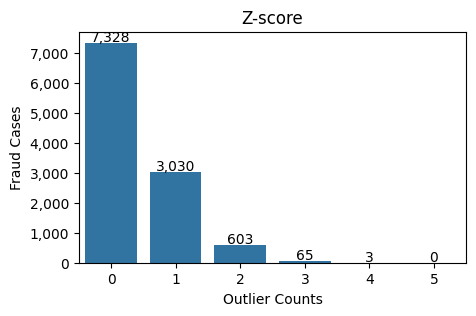

In [29]:
draw_outlier_barplot(outlier_method_and_result_list[0][1], label_zscore)

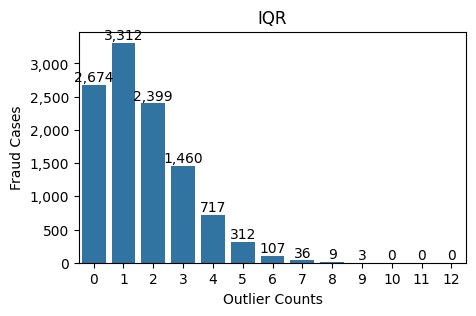

In [30]:
draw_outlier_barplot(outlier_method_and_result_list[1][1], label_iqr)

The two histograms above indicate that detecting more outliers in features does not necessarily improve fraud detection. In fact, features with fewer outlier counts tend to correspond to a higher number of fraud cases.

Let's take a closer look at the features with the highest outlier counts that are also marked as "fraud."

In [31]:
# Initialize an empty dataframe
df_feature_outlier_result = pd.DataFrame(columns=[label_feature, label_count], dtype=int)

# Initialize outlier counter
outlier_flag_series = pd.Series(0, index=df.index, name = label_outlier_count)

for method_idx in range(len(outlier_method_and_result_list)):
  for col in X_no_string_or_bool.columns:
    match str(outlier_method_and_result_list[method_idx][0]):
      case 'Z-score':
        outlier_flag_series = get_zscore_per_col(X_no_string_or_bool[col])
      case 'IQR':
        outlier_flag_series = get_iqr_per_col(X_no_string_or_bool[col])
      case _: # the default wild card
        print("Error")

    # Count the number of rows where both "fraud_bool" and the derived outlier by the model MACTH, i.e., multiplication of both values in the row results in 1
    # No need to specify column name for a Series like:
    #   count = (y[label_target] * outlier_flag_series[outlier_count_col_title] == 1).sum()
    count = (y * outlier_flag_series == 1).sum()

    # Add the result to the first dataframe using loc
    df_feature_outlier_result.loc[len(df_feature_outlier_result)] = [col, count]

  # Add it to the list as a second element
  outlier_method_and_result_list[method_idx].append(df_feature_outlier_result.copy(deep=True))

  # This removes all rows but retains the column names and data types.
  df_feature_outlier_result.drop(df_feature_outlier_result.index, inplace=True)

In [32]:
def draw_outlier_by_feature_barplot(data: pd.DataFrame,
                                    method_name: str) -> None:
# data:
#     Feature Count
# 18 	None 	None
# 19 	income 	0
# 21 	prev_address_months_count 	575

# In a row, When 'Feature' and 'Count' shows
# 1. Both 'None'
#   The particular feature is never counted as an outlier by the method chosen
# 2. Feature name printed and 0
#   The particular feature is counted as an outlier BUT no fraud case is found when its value is an ourlier
# 3. Feature name printed and non-zero
#   The particular feature is counted as an outlier AND one or more fraud case is found

  # Drop rows where both 'Feature' and 'Count' are None
  data_none_removed = data.dropna(subset=[label_feature, label_count], how='all')

  # Sort in a descending order
  data_none_removed = data_none_removed.sort_values(by=label_count, ascending=False)

  plt.figure(figsize=(5, 3))
  ax = sns.barplot(x=label_count, y=label_feature, data=data_none_removed, orient="h")

  # Do not need this as the Y-axis shows categorical values, only the X-axis
  ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))

  # for idx in range(len(data)):
  #   ax.text(idx, data[label_target][idx] + 50, f"{data[label_target][idx]:,.0f}", ha="center", fontsize=10)
  ax.bar_label(ax.containers[0], fmt="{:,.0f}")
  # ax.bar_label(ax, fmt="{:,.0f}")

  # Adding labels and title
  plt.xlabel(label_fraud_count)
  plt.ylabel(label_feature)
  plt.title(method_name)
  plt.show()

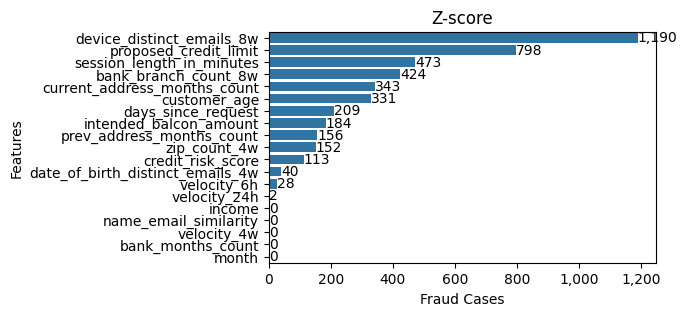

In [33]:
draw_outlier_by_feature_barplot(outlier_method_and_result_list[0][2], label_zscore)

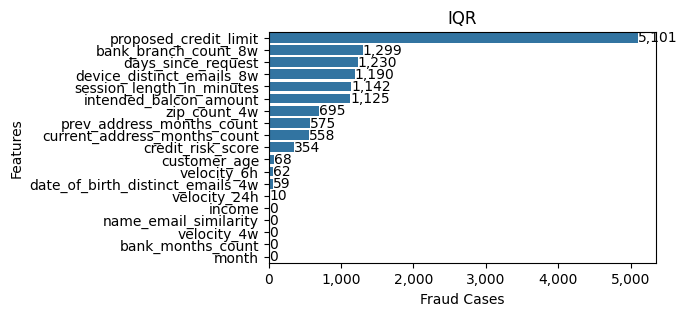

In [34]:
draw_outlier_by_feature_barplot(outlier_method_and_result_list[1][2], label_iqr)

Based on the observed outliers, the **proposed_credit_limit** identified by the IQR method carries more weight in predicting fraud than **device_distinct_emails_8w** identified by the Z-score method.

I have not overlooked binary and categorical features. I briefly examine them to determine if any notable patterns emerge in relation to detected fraud.

In [35]:
def get_fraud_count_by_single_dtype(df: pd.DataFrame, dtype_name: str) -> list:
  df_selected_dtype = df.select_dtypes(dtype_name)
  list_of_list_col_names = [[col_name] for col_name in df_selected_dtype.columns]

  for list_col in list_of_list_col_names:
    # put 'fraud_bool' (y) and a boolean/encoded valued column together into a new DataFrame
    df_concatenated = pd.concat([y,  df_selected_dtype[list_col[0]]], axis=1)

    # Change column names for FacetGrid later
    df_concatenated.rename(columns={list_col[0]: label_value}, inplace=True)
    df_concatenated.rename(columns={label_target: label_fraud_count}, inplace=True)

    # Group by "label_value" and sum the "label_fraud_count"
    # Convert back to a regular DataFrame using the reset_index() method
    df_concatenated_grouped = df_concatenated.groupby(label_value)[label_fraud_count].sum().reset_index()

    # Add it to the list as a second element
    list_col.append(df_concatenated_grouped)

  return list_of_list_col_names


def get_fraud_count_in_facetgrid(list_source: list) -> None:
  # Combine data into a single DataFrame
  # Need to use "##{varName}" to dynamically assign a variable name as a column name of the combined DataFrame
  df_combined = pd.concat(
      [df_bool.assign(**{label_feature:feature_name}) for feature_name, df_bool in list_source],
      ignore_index=True
  )

  g = sns.FacetGrid(df_combined, col=label_feature)
  ax = sns.barplot
  g.map_dataframe(ax, x=label_value, y=label_fraud_count)

  g.set(xlabel=None)

  # Apply the formatter to each axis in the FacetGrid
  for ax in g.axes.flat:
    # ax.yaxis.set_major_formatter(FuncFormatter("{x:,.0f}"))
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))
    ax.bar_label(ax.containers[0], fmt="{:,.0f}")
  plt.show()

In [36]:
list_bool_fraud_counts = get_fraud_count_by_single_dtype(X, 'bool')

    Values  Fraud Cases            Features
0    False         3738       email_is_free
1     True         7291       email_is_free
2    False         8238    phone_home_valid
3     True         2791    phone_home_valid
4    False         1648  phone_mobile_valid
5     True         9381  phone_mobile_valid
6    False        10098     has_other_cards
7     True          931     has_other_cards
8    False        10474     foreign_request
9     True          555     foreign_request
10   False         7261  keep_alive_session
11    True         3768  keep_alive_session


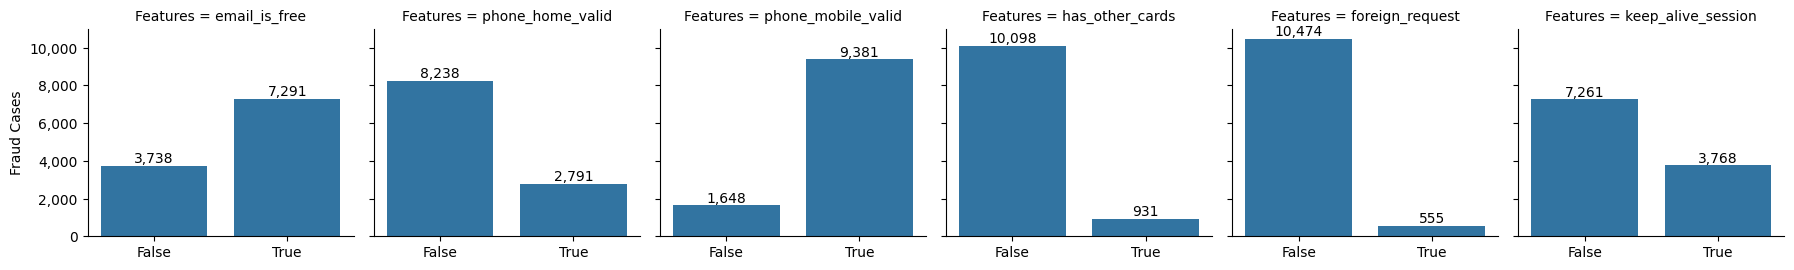

In [37]:
get_fraud_count_in_facetgrid(list_bool_fraud_counts)

The features **phone_mobile_valid**, **has_other_cards**, and **foreign_request** show a noticeable contrast between their True and False values. I will further analyze them using a Confusion Matrix.


In [66]:
# def get_confusion_matrix(df: pd.DataFrame, col_name: str) -> None:
def get_confusion_matrix(data, col_name: str) -> None:
  # With unsupervised machine learning, data comes in the form of np.ndarray, so convert it to DataFrame
  df = pd.DataFrame(data, columns=[col_name]) if isinstance(data, np.ndarray) else data

  # In the binary case like this, extract true positives, etc. as follows
  # Two sets of swappings are necessary TN <-> TP & FN <-> FP!
  # normal quadrants = {
  # "True Negative (TN)": cm[0][0],
  # "False Positive (FP)": cm[0][1],
  # "False Negative (FN)": cm[1][0],
  # "True Positive (TP)": cm[1][1]
  # }

  # binary quadrants = {
  # "True Negative (TN)": cm[1][1],
  # "False Positive (FP)": cm[1][0],
  # "False Negative (FN)": cm[0][1],
  # "True Positive (TP)": cm[0][0]
  # }

  tn, fp, fn, tp = confusion_matrix(y, df[col_name]).ravel()

  # E.g. correct_cm = [np.int64(9381), np.int64(880295), np.int64(1648), np.int64(108676)]
  # Cconvert "np.int64" to "int"
  cm_in_int = np.array(
                        [
                          [int(tp), int(fn)],
                          [int(fp), int(tn)],
                        ]
                      )

  flattened_cm_in_int = cm_in_int.flatten()
  total_count = np.sum(cm_in_int)

  group_counts = ["{0:,.0f}".format(value) for value in flattened_cm_in_int]
  group_percentages = ["{0:.2%}".format(value) for value in flattened_cm_in_int/total_count]
  group_counts = ["{0:,.0f}".format(value) for value in flattened_cm_in_int]
  group_percentages = ["{0:.2%}".format(value) for value in flattened_cm_in_int/total_count]
  labels = [f"{g1}\n({g2})" for g1, g2 in zip(group_counts,group_percentages)]

  # As of now, labels is a one-dimentional array i.e., [...]
  # Convert it to an array of arrays
  labels = np.asarray(labels).reshape(y.nunique(), df[col_name].nunique())
  plt.figure(figsize=(4, 2))
  heatmap = sns.heatmap(cm_in_int, annot=labels, fmt="", cbar=False, cmap="coolwarm", xticklabels=["True", "False"], yticklabels=["True", "False"])

  # Apply the formatter to the colorbar
  colorbar = heatmap.collections[0].colorbar

  # Automatically set the ticks based on the data range
  # Number of ticks = 8 (default on Heatmap)
  # colorbar.set_ticks(np.linspace(max(quadrants.values()), max(quadrants.values()), 8))
  # colorbar.set_ticks([1000, 10000, 50000, 100000])
  # colorbar.set_ticklabels([format_thousands(x, None) for x in colorbar.get_ticks()])
  # colorbar.ax.yaxis.set_major_formatter(FuncFormatter(format_thousands))

  plt.xlabel(col_name)
  plt.ylabel(label_fraud)
  plt.title('Confusion Matrix')
  plt.show()

[['9,381\n(0.94%)' '1,648\n(0.16%)']
 ['880,295\n(88.03%)' '108,676\n(10.87%)']]


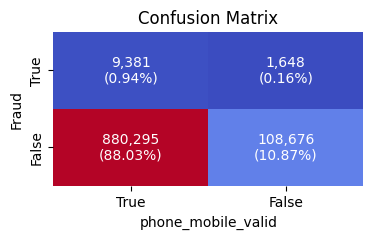

In [39]:
get_confusion_matrix(X, "phone_mobile_valid")

[['931\n(0.09%)' '10,098\n(1.01%)']
 ['222,057\n(22.21%)' '766,914\n(76.69%)']]


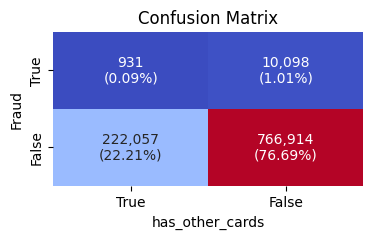

In [ ]:
get_confusion_matrix(X, "has_other_cards")

[['555\n(0.06%)' '10,474\n(1.05%)']
 ['24,687\n(2.47%)' '964,284\n(96.43%)']]


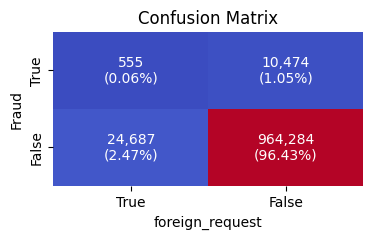

In [ ]:
get_confusion_matrix(X, "foreign_request")

Essentially, the previous section presents only the last rows, where the Fraud flag is true, of each confusion matrix above, which does not provide a comprehensive depiction of the details.

Consequently, this demonstrates that comparing individual feature counts directly to fraudulent transaction counts does not effectively identify key influential features. Moreover, it fails to uncover the underlying relationships among features that contribute to fraudulent activity in a more complex manner.

In [ ]:
def get_heatmap_for_categorical_feature(col_name: str) -> None:
  # First combine the target column and "col_name"
  df_combined = pd.concat([y, X[col_name]], axis=1)

  # Get the count matrix
  count_matrix = df_combined.groupby([label_target, col_name]).size().unstack(fill_value=0)

  # Currently, it looks something like this where fraud value of 1 (True) is positioned in the second row
  # payment_type      AA      AB      AC      AD   AE
  # fraud_bool
  # 0             256885  366385  247862  117551  288
  # 1               1364    4169    4209    1286    1

  # Swap the first and second rows, so that it aligns with the Confusion matrix style
  count_matrix = count_matrix.iloc[[1, 0]]

  # The first "sum()" only does for the columns separately, so give it another "sum()" for the entire DataFrame
  total_count = count_matrix.sum().sum()
  percent_data = count_matrix.map(lambda x: f"{x:,.0f}\n({x/total_count:.1%})")

  # Plot heatmap
  plt.figure(figsize=(6, 2))
  ax = sns.heatmap(count_matrix, annot=percent_data, fmt="", cmap="coolwarm", linewidths=0.5, cbar=False, yticklabels=["True", "False"])

  plt.title("Heatmap of \"" + col_name + "\"")
  plt.xlabel("Values")
  plt.ylabel(label_fraud)
  plt.show()



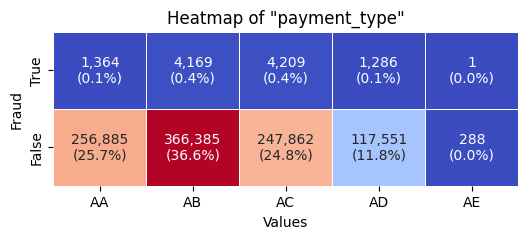

In [ ]:
get_heatmap_for_categorical_feature("payment_type")

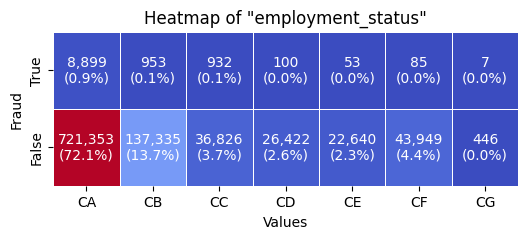

In [ ]:
get_heatmap_for_categorical_feature("employment_status")

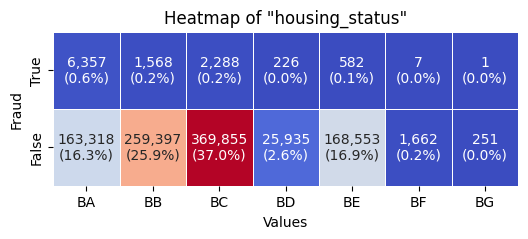

In [ ]:
get_heatmap_for_categorical_feature("housing_status")

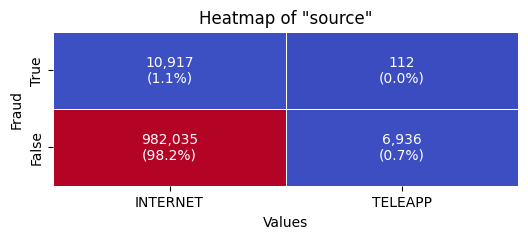

In [ ]:
get_heatmap_for_categorical_feature("source")

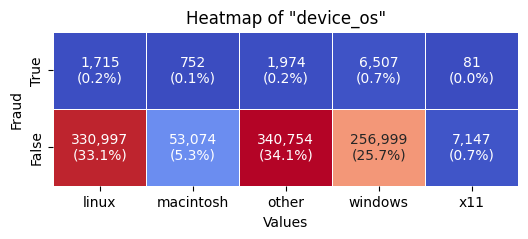

In [ ]:
get_heatmap_for_categorical_feature("device_os")

As with the previous binary feature heatmaps, no single categorical feature stands out as a strong predictor of fraudulent transactions.

[The challenges of AML transaction monitoring](https://linkurious.com/transaction-monitoring-in-aml/#the-challenges-of-aml-transaction-monitoring) succinctly summarize the ever-evolving nature of this practice.  
> "Many AML transaction monitoring systems depend on static rules to flag potentially suspicious behavior. These systems do a good job of turning up known anomalies - but they don’t take context into account and often miss part of the picture.

> "These traditional rules-based monitoring systems also often generate **a high number of false positives** (this scenario), overwhelming investigators with alerts and making it challenging to distinguish genuine threats from noise."

> "At the same time, money launderers are becoming increasingly sophisticated in disguising their illicit activities. They adapt to the rules flagged by transaction monitoring to fly under the radar, leading to false negatives.This underscores the necessity for institutions to adopt more advanced and adaptive solutions."

This is where, I strongly believe, Artificial Intelligence (AI) becomes a game-changer.

    True Label  Predicted Label  Count
0            0                0     52
1            0                1      0
2            0                2      0
3            0                3      0
4            0                4      1
..         ...              ...    ...
95           9                5      0
96           9                6      0
97           9                7      1
98           9                8      1
99           9                9     57

[100 rows x 3 columns]


AttributeError: QuadMesh.set() got an unexpected keyword argument 'x'

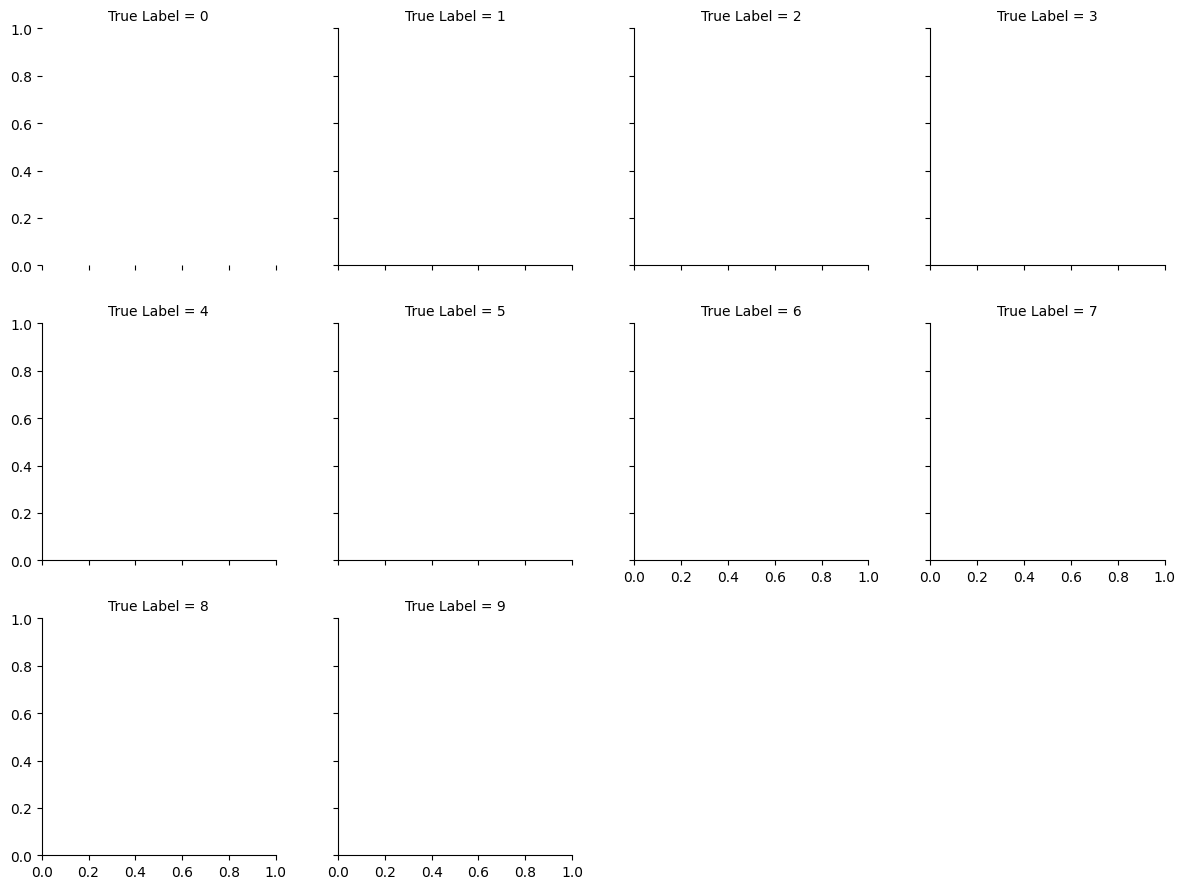

In [86]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_digits

# Load sample dataset
digits = load_digits()
X, y = digits.data, digits.target

# Splitting data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train a classifier
model = RandomForestClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Create confusion matrix for each class
cm = confusion_matrix(y_test, y_pred)

# Convert confusion matrix into a DataFrame for Seaborn
cm_df = pd.DataFrame(cm, columns=digits.target_names, index=digits.target_names)
cm_df = cm_df.stack().reset_index()
cm_df.columns = ['True Label', 'Predicted Label', 'Count']

print(cm_df)
# Create Seaborn FacetGrid to visualize confusion matrices for each class
g = sns.FacetGrid(cm_df, col="True Label", col_wrap=4, height=3)
g.map_dataframe(sns.heatmap, "Count", annot=True, fmt="d", cmap="Blues")

plt.show()

#### Imbalanced Dataset
---
An **imbalanced dataset** is a dataset where the distribution of classes is **not equal**. This typically occurs in classification problems where one class has significantly more samples than another.

In our case, only a small percentage of transactions are fraudulent, while the majority are legitimate.

##### **Challenges of Imbalanced Datasets:**  
- 🚫 Bias in models – Machine learning models tend to favor the majority class.  
- 🚫 Poor predictive performance – Standard accuracy metrics can be misleading because predicting only the majority class may still yield high accuracy.  
- 🚫 Harder to detect rare cases – The model struggles to learn patterns in the minority class.  

##### **Solutions for Handling Imbalanced Datasets:**
✅ **Resampling Techniques:**
   - Oversampling (Duplicate minority class samples)
   - Undersampling (Reduce majority class samples)
   - Synthetic Sampling (SMOTE) (Generate artificial data points)

✅ **Use Better Metrics (see this easy-to-follow [Google crash course](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc)):**  
   - Precision, Recall, F1-score
   - ROC-AUC & Precision-Recall curves

✅ **Change Model Strategy:**  
   - Use weighted loss functions to give more importance to the minority class.
   - Try **ensemble methods** like boosting (e.g., XGBoost) that handle imbalances well.

In [40]:
# Each of the following methods take a long compute time, so let us measure it
import time

def measure_duration(start_time: float) -> None:
  end_time = time.time()
  duration = end_time - start_time
  hours = int(duration // 3600)
  minutes = int((duration % 3600) // 60)
  seconds = duration % 60
  formatted_duration = f"Duration: {hours} hours, {minutes} minutes, and {seconds:.2f} seconds"
  print(formatted_duration)

In [84]:
from sklearn.metrics import precision_score, recall_score, f1_score

def get_precision_recall_f1_scores(arr: np.ndarray) -> tuple:
  # # Sample true labels and predicted labels
  # y_true = [1, 0, 1, 1, 0, 1, 0, 0, 1, 0]  # Actual class labels
  # y_pred = [1, 0, 1, 0, 0, 1, 0, 0, 1, 1]  # Predicted class labels

  # Calculate precision, recall, and F1-score
  # precision = precision_score(y, arr)
  # recall = recall_score(y, arr)
  # f1 = f1_score(y, arr)

  # print(f"Precision: {precision:.2f}")
  # print(f"Recall: {recall:.2f}")
  # print(f"F1-score: {f1:.2f}")
  return (precision_score(y, arr), recall_score(y, arr), f1_score(y, arr))

In [41]:
# Initialize an empty dataframe
# This stores the fraud hit counts by each method
df_method_ourlier_result = pd.DataFrame(columns=[label_method, label_count, label_precision, label_recall, label_f1score], dtype=int)

2. Density-based Method (Density-Based Spatial Clustering of Applications with Noise (DBSCAN))
---

In [42]:
from sklearn.cluster import DBSCAN

start_time = time.time()

# Density-Based Spatial Clustering of Applications with Noise
dbscan = DBSCAN(eps=1.5, min_samples=2)
labels = dbscan.fit_predict(X_standard_scaled)

# Mark outliers (DBSCAN labels outliers as -1)
dbscan_outliers = (labels == -1)

# Count the number of rows where both "fraud_bool" and the derived outlier by the model MACTH, i.e., multiplication of both values in the row results in 1
dbscan_outlier_count = (y * dbscan_outliers == 1).sum()
precision, recall, f1 = get_precision_recall_f1_scores(dbscan_outliers)
df_method_ourlier_result.loc[len(df_method_ourlier_result)] = ["DBSCAN", dbscan_outlier_count, precision, recall, f1]

measure_duration(start_time)

Duration: 0 hours, 38 minutes, and 42.00 seconds


True
<class 'pandas.core.frame.DataFrame'>
0          True
1         False
2         False
3         False
4          True
          ...  
999995    False
999996    False
999997     True
999998    False
999999    False
Name: Predicted Values, Length: 1000000, dtype: bool
   Predicted Values
0              True
1             False
2             False
3             False
4              True


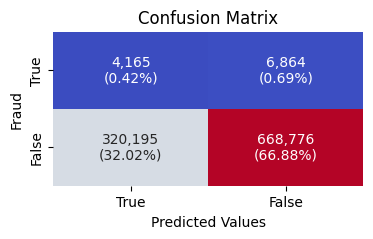

()

In [67]:
get_confusion_matrix(dbscan_outliers, "DBSCAN")

3. Machine Learnig-based Method (One-Class Support Vector Machine (SVM))
---

In [ ]:
from sklearn.svm import OneClassSVM

start_time = time.time()

oc_svm = OneClassSVM(kernel="rbf", nu=0.05)  # Adjust 'nu' for sensitivity
oc_svm.fit(X_standard_scaled)

# Predict outliers (-1 = outlier, 1 = normal)
predictions = oc_svm.predict(X_standard_scaled)

# Mark outliers in DataFrame
oc_svm_outliers = (predictions == -1)

# Count the number of rows where both "fraud_bool" and the derived outlier by the model MACTH, i.e., multiplication of both values in the row results in 1
oc_outlier_count = (y * oc_svm_outliers == 1).sum()
precision, recall, f1 = get_precision_recall_f1_scores(oc_svm_outliers)
df_method_ourlier_result.loc[len(df_method_ourlier_result)] = ["OneClassSVM" oc_outlier_count, precision, recall, f1]

measure_duration(start_time)

4. Probability-based Method (Gaussian Mixiture Model (GMM))
---

In [ ]:
from sklearn.mixture import GaussianMixture

start_time = time.time()

gmm = GaussianMixture(n_components=2, covariance_type="full", random_state=42)
gmm.fit(X_standard_scaled)

# Compute probability scores
probs = gmm.predict_proba(X_standard_scaled).max(axis=1)

# Set threshold (low probability = outlier)
threshold = np.percentile(probs, 5)  # 5th percentile
gmm_outliers = (probs < threshold)

# Count the number of rows where both "fraud_bool" and the derived outlier by the model MACTH, i.e., multiplication of both values in the row results in 1
gmm_outlier_count = (y * gmm_outliers == 1).sum()
precision, recall, f1 = get_precision_recall_f1_scores(gmm_outliers)
df_method_ourlier_result.loc[len(df_method_ourlier_result)] = ["GMM", gmm_outlier_count, precision, recall, f1]]

measure_duration(start_time)

5. Distance-based Method (K-Nearest Neighbors (KNN))
---

In [ ]:
from sklearn.neighbors import NearestNeighbors

start_time = time.time()

nbrs = NearestNeighbors(n_neighbors=3)
nbrs.fit(X_standard_scaled)
distances, indices = nbrs.kneighbors(X_standard_scaled)

# Compute the mean distance to k-nearest neighbors
mean_distances = distances.mean(axis=1)

# Set threshold as the 95th percentile
threshold = np.percentile(mean_distances, 95)

knn_outliers = (mean_distances > threshold)

# Count the number of rows where both "fraud_bool" and the derived outlier by the model MACTH, i.e., multiplication of both values in the row results in 1
knn_outlier_count = (y * knn_outliers == 1).sum()
precision, recall, f1 = get_precision_recall_f1_scores(knn_outliers)
df_method_ourlier_result.loc[len(df_method_ourlier_result)] = ["KNN", knn_outlier_count, precision, recall, f1]

measure_duration(start_time)

Precision or Recall?
---

### **Precision (Positive Predictive Value)**
- Precision tells you how **many of the positive predictions** made by your model are actually **correct**.
- It's especially important in cases where **false positives** (incorrectly labeling something as positive) have serious consequences.
- **Example**: In **spam detection**, high precision means that most emails marked as spam are indeed spam, minimizing the risk of wrongly filtering out important emails.

### **Recall (Sensitivity or True Positive Rate)**
- Recall indicates how **many actual positive cases** your model correctly identified.
- It's crucial in scenarios where **false negatives** (failing to identify a positive case) can be costly.
- **Example**: In **medical diagnosis**, high recall ensures that most patients with a condition are correctly diagnosed, reducing the chances of missing a serious illness.

When analyzing bank account fraud using transaction data, the choice between focusing on recall or precision depends on the specific goals and risks involved.

- **Precision**: Measures how many flagged transactions are truly fraudulent. A high precision ensures fewer false alarms, meaning legitimate transactions aren't wrongly blocked.
- **Recall** (Sensitivity): Measures how well the model identifies fraudulent transactions. A high recall ensures that most fraudulent cases are caught, but it might also include false positives (legitimate transactions flagged as fraud).

### Which one to prioritize?
- If **missing fraudulent transactions** is riskier (e.g., fraud leads to significant financial loss), then **high recall** is crucial.
- If **false positives** disrupt customer experience (e.g., legitimate transactions get blocked), then **high precision** is more important.
- A balanced **F1-score** (harmonizing recall and precision) may be best for real-world fraud detection.

Typically, fraud detection leans toward **higher recall**, ensuring fraudsters don't slip through, but precision matters too to avoid customer frustration. Banks often use a combination with fine-tuned thresholds.

In [77]:
# def draw_outlier_by_method_barplot(data: pd.DataFrame) -> None:
#   # Sort in a descending order by count
#   data = data.sort_values(by=label_count, ascending=False)

#   plt.figure(figsize=(4, 2))
#   ax = sns.barplot(x=label_count, y=label_method, data=data, orient="h")

#   ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))
#   # ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))
#   ax.bar_label(ax.containers[0])

#   # Adding labels and title
#   plt.xlabel(label_fraud_count)
#   plt.ylabel(label_method)
#   plt.title(label_outlier_count + " (out of " + str(total_fraud_count) + ")")
#   plt.show()

In addition to precision, recall, and F1-score, another useful metric is the Receiver Operating Characteristic (ROC) curve. This plot illustrates the trade-off between the true positive rate and false positive rate across different threshold values. The area under the curve (AUC) provides a quantifiable measure of the model's overall performance.

In [82]:
from sklearn.metrics import roc_curve, auc

def get_roc_curve(arr_preds: np.ndarray) -> None:
  # print(isinstance(array, list))   # Falseprint(isinstance(array, np.ndarray))  # True

  # Convert to numpy.ndarray
  # numpy_array = series.to_numpy()

  # Sample data
  # y_true = [0, 1, 0, 1, 0, 1, 1, 0]  # Actual labels
  # y_scores = [0.1, 0.4, 0.35, 0.8, 0.2, 0.7, 0.9, 0.6]  # Predicted scores

  # Calculate ROC curve
  fpr, tpr, _ = roc_curve(y.to_numpy(), arr_preds)
  roc_auc = auc(fpr, tpr)

  # Plot ROC curve
  plt.figure(figsize=(3, 2))
  plt.plot(fpr, tpr, color="blue", lw=2, label="ROC curve (area = %0.2f)" % roc_auc)
  plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel("False Positive Rate")
  plt.ylabel("True Positive Rate")
  plt.title("ROC Curve")
  plt.legend(loc="lower right")

  plt.show()

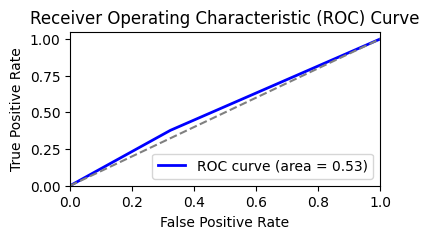

In [83]:
get_roc_curve(dbscan_outliers)

So far they are all useless. Now what?
---
Up to this point, I have not trained a single model using actual fraud labeling data. Now, it’s time to do exactly that and evaluate how these models perform.

Some of the most popular supervised binary classification models include:  
1️⃣ Logistic Regression

    - A simple yet effective model for fraud detection.
    - Works well when fraud patterns are linear and interpretable.

2️⃣ Random Forest

    - An ensemble of decision trees that improves accuracy.
    - Helps detect complex fraud patterns and reduces overfitting.

3️⃣ Gradient Boosting (XGBoost, LightGBM, CatBoost)

    - Powerful models that handle imbalanced datasets well.
    - Often used in financial fraud detection due to their precision.

4️⃣ Support Vector Machines (SVM)

    - Finds the optimal boundary between fraudulent and legitimate transactions.
    - Works well for high-dimensional financial data.

5️⃣ Neural Networks (Deep Learning)

    - Can learn complex fraud patterns from transaction data.
    - Used in real-time fraud detection systems.


Feature engineering
---
Have I just convinced myself that models, whether supervised or unsupervised, perform poorly in detecting fraud through outlier detection and machine learning?

This outcome is not surprising. I strongly believe that the dataset’s 30 features make fraud prediction overly complex—even for sophisticated machine learning methods.

Feature engineering enhances a model’s capability by eliminating uninformative features that do not contribute to accurate predictions. This refinement process often relies on human expertise, as **domain knowledge** provides valuable insights that machine learning alone could never deduce.

Feature selection methods use labeled data to identify the most relevant features for a given prediction task. Here are some key techniques:

### **1. Filter Methods**
These techniques assess individual feature relevance without involving a specific model.
- **Mutual Information**: Measures the dependency between features and target variables.
- **Chi-Square Test**: Evaluates categorical features based on statistical significance with class labels.
- **ANOVA (Analysis of Variance)**: Determines feature importance based on variance analysis for continuous variables.
- **Correlation-Based Methods**: Selects features highly correlated with the target but minimally correlated with each other.

### **2. Wrapper Methods**
These techniques involve training a model and iteratively selecting the best subset of features.
- **Recursive Feature Elimination (RFE)**: Eliminates features recursively while tracking model performance.
- **Sequential Feature Selection (SFS/SBS)**: Adds or removes features step by step to maximize performance.
- **Feature Importance from Tree-Based Models**: Uses models like Random Forest or Gradient Boosting to determine feature relevance.

### **3. Embedded Methods**
These techniques perform feature selection during model training.
- **Lasso Regression (L1 Regularization)**: Shrinks less important feature coefficients to zero.
- **Elastic Net Regularization**: Combines L1 and L2 penalties to improve feature selection.
- **Tree-Based Feature Importance**: Decision trees and ensemble models inherently rank features during training.

Mutual information feature selection can be quite useful in a supervised binary classification setting. It helps identify the most relevant features by measuring the amount of information a given feature shares with the target variable. Here’s why it’s valuable:

- **Captures Non-Linear Dependencies**: Unlike correlation-based methods, mutual information can detect both linear and non-linear relationships between features and the target.
- **Improves Model Efficiency**: By selecting only the most informative features, it reduces dimensionality, speeds up training, and enhances generalization.
- **Handles Mixed Data Types**: Mutual information works for categorical and continuous data alike, making it versatile across different datasets.

However, it does have limitations:
- **Computational Cost**: Estimating mutual information can be computationally expensive, especially with large datasets.
- **Feature Redundancy**: If multiple features provide similar information, mutual information might not effectively filter them out.

In practice, mutual information is often combined with other techniques—like recursive feature elimination or regularization-based selection—to get the best results.

Laatly, I will build a model by combining **Mutual Information (MI)** with **Recursive Feature Elimination (RFE)** that can be a powerful way to refine my feature selection for a binary classification model.  

### **Step 1: Import Necessary Libraries**
You'll need `mutual_info_classif`, `RFE`, and a classifier (like `RandomForestClassifier` or `LogisticRegression`).

```python
import numpy as np
import pandas as pd
from sklearn.feature_selection import mutual_info_classif, RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
```

---

### **Step 2: Load & Prepare Data**
Let's assume we have a dataset `df` with features and a target column named `'target'`.

```python
X = df.drop(columns=['target'])  # Features
y = df['target']  # Target variable
```

---

### **Step 3: Compute Mutual Information Scores**
Find the most informative features using **Mutual Information**.

```python
mi_scores = mutual_info_classif(X, y, random_state=42)
mi_series = pd.Series(mi_scores, index=X.columns).sort_values(ascending=False)

# Set a threshold and select top features
mi_threshold = 0.01  # Adjust as needed
selected_features = mi_series[mi_series > mi_threshold].index
X_selected = X[selected_features]

print("Selected Features from Mutual Information:", selected_features)
```

This filters out features with low information gain.

---

### **Step 4: Apply Recursive Feature Elimination (RFE)**
Now, use **RFE** to further refine the feature set. You can use a classifier as an estimator.

```python
# Define a base model for RFE (e.g., Logistic Regression or Random Forest)
model = LogisticRegression(max_iter=1000, random_state=42)

# Perform RFE with a chosen number of features
rfe = RFE(estimator=model, n_features_to_select=5)  # Adjust based on dataset size
X_rfe_selected = rfe.fit_transform(X_selected, y)

# Get final feature names
final_selected_features = X_selected.columns[rfe.support_]
print("Final Selected Features after RFE:", final_selected_features)
```

---

### **Step 5: Train & Evaluate Model Using Selected Features**
Now, use the **filtered** features for training.

```python
X_train, X_test, y_train, y_test = train_test_split(X_selected[final_selected_features], y, test_size=0.2, random_state=42)

# Train a classifier
final_model = RandomForestClassifier(random_state=42)
final_model.fit(X_train, y_train)

# Evaluate
print("Final Model Accuracy:", final_model.score(X_test, y_test))
```

---

### **Summary**
1. **Mutual Information** eliminates irrelevant features based on information gain.
2. **Recursive Feature Elimination (RFE)** removes redundant features by iteratively selecting the best subset.
3. The final model trains only on the most **meaningful** features.

Would you like me to optimize this pipeline further or adapt it to a specific dataset? 🚀


In [ ]:
import numpy as np
from scipy.stats import zscore

# Function to detect outliers using Z-score & IQR
def detect_outliers(df):
    outlier_indices = {}

    for col in df.select_dtypes(include=[np.number]).columns:
        print(f"\nChecking column: {col}")

        # Z-score method
        z_scores = zscore(df[col])
        z_outliers = df[col][(np.abs(z_scores) > 3)]

        # IQR method
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        iqr_outliers = df[col][((df[col] < (Q1 - 1.5 * IQR)) | (df[col] > (Q3 + 1.5 * IQR)))]

        # Store results
        outlier_indices[col] = {
            "Z-score Outliers": z_outliers.tolist(),
            "IQR Outliers": iqr_outliers.tolist()
        }

        print(f"Z-score outliers: {z_outliers.tolist()}")
        print(f"IQR outliers: {iqr_outliers.tolist()}")

    return outlier_indices

# Identify outliers
outliers = detect_outliers(df)


In [ ]:
from sklearn.feature_selection import mutual_info_classif

# discrete_features=True for categorical variable
mi_scores = mutual_info_classif(X, y, discrete_features='auto')

# Convert to a DataFrame for clarity
mi_results = pd.DataFrame({'Feature': X.columns, 'Mutual_Information': mi_scores})
mi_results.sort_values(by='Mutual_Information', ascending=False, inplace=True)

print(mi_results)

In [ ]:
from sklearn.feature_selection import mutual_info_regression

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = make_mi_scores(X, y, discrete_features)
print(mi_scores)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

# from matplotlib import style
# print(plt.style.available)
plt.style.use("seaborn-v0_8-whitegrid")
plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores)

In [ ]:
import seaborn as sns

sns.relplot(x="device_distinct_emails_8w", y="fraud_bool", data=df);

In [ ]:
# The keyword "pandas==" without prefix "^" fetches the following entry that is NOT wanted
#   sklearn-pandas==2.2.0


!pip freeze | grep -E '^tqdm==|^pandas==|^google=='